In [ ]:
!pip install torchmetrics

In [ ]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nb

In [ ]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.2/688.2 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from glob import glob
import trimesh
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3

from open3d.web_visualizer import draw

import matplotlib as mpl
%matplotlib inline

[Open3D INFO] Resetting default logger to print to terminal.


In [ ]:
#to remove unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive

DATA_DIR = "./data"  # You can change this to your desired directory

# URL for ModelNet10 dataset
url = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"

# Download and extract the dataset
download_and_extract_archive(url, download_root=DATA_DIR, extract_root=DATA_DIR)

# Now DATA_DIR contains the extracted ModelNet10 dataset


100%|██████████| 473402300/473402300 [00:11<00:00, 40465768.81it/s]


Extracting ./data/ModelNet10.zip to ./data


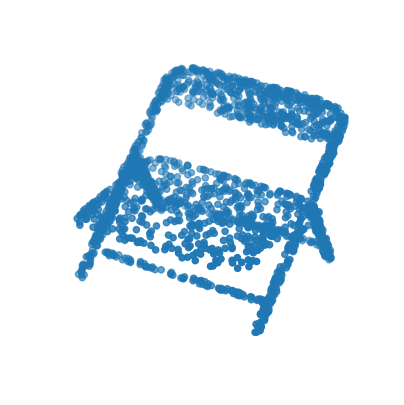

In [ ]:

mesh = trimesh.load(os.path.join(DATA_DIR, "ModelNet10/chair/train/chair_0001.off"))

# sample point from
mesh.show()
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
# function to parse dataset
import glob
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "ModelNet10/[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        torch.Tensor(train_points),
        torch.Tensor(test_points),
        torch.Tensor(train_labels),
        torch.Tensor(test_labels),
        class_map,
    )


NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: sofa
processing class: chair
processing class: bathtub
processing class: night_stand
processing class: desk
processing class: dresser
processing class: bed
processing class: toilet
processing class: table
processing class: monitor


In [ ]:
print(f"Train Feature shape: {train_points.size()}")
print(f"Train Labels shape: {train_labels.size()}")
print(f"Test Feature shape: {test_points.size()}")
print(f"Test Labels shape: {test_labels.size()}")

Train Feature shape: torch.Size([3991, 2048, 3])
Train Labels shape: torch.Size([3991])
Test Feature shape: torch.Size([908, 2048, 3])
Test Labels shape: torch.Size([908])


In [ ]:
CLASS_MAP

{0: 'sofa',
 1: 'chair',
 2: 'bathtub',
 3: 'night_stand',
 4: 'desk',
 5: 'dresser',
 6: 'bed',
 7: 'toilet',
 8: 'table',
 9: 'monitor'}

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle

def augment(points, label):
    # jitter points
    points += torch.rand_like(points) * 0.01 - 0.005
    # shuffle points
    indices = torch.randperm(points.shape[0])
    points = points[indices]
    return points, label

class PointCloudDataset(Dataset):
    def __init__(self, points, labels):
        self.points = points
        self.labels = labels

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return {'points': self.points[idx], 'labels': self.labels[idx]}

# Assuming train_points, train_labels, test_points, and test_labels are already defined

# Create datasets and apply augmentation
train_dataset = PointCloudDataset(train_points, train_labels)
test_dataset = PointCloudDataset(test_points, test_labels)

# Shuffle the training data
train_dataset.points, train_dataset.labels = shuffle(train_dataset.points, train_dataset.labels)

# Apply augmentation to the training dataset
train_dataset.points, train_dataset.labels = augment(train_dataset.points, train_dataset.labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example usage in the training loop
for batch in train_loader:
    points, labels = batch['points'], batch['labels']
    # Your training logic here


In [ ]:
train_loader

In [ ]:
total_train_targets = []
for batch in train_loader:
    targets = batch['labels']
    total_train_targets += targets.view(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

Text(0.5, 1.0, 'Train Class Frequencies')

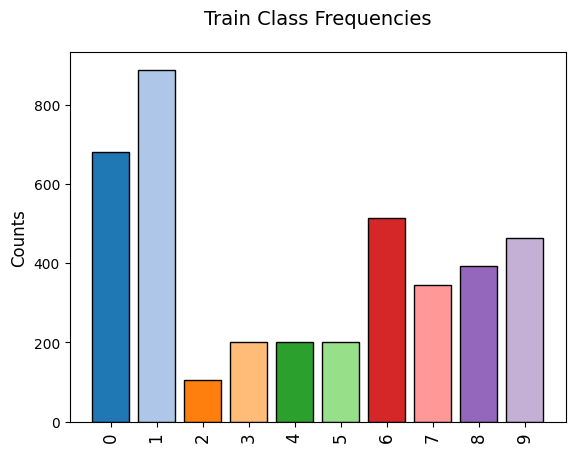

In [ ]:
class_bins = np.bincount(total_train_targets.astype(int))

plt.bar(list(CLASS_MAP.keys()), class_bins,
        color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
        edgecolor='black')
plt.xticks(list(CLASS_MAP.keys()), list(CLASS_MAP.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20)


In [ ]:
class Tnet(nn.Module):
    def __init__(self, dim, num_points=2048):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)


    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)

        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x

In [ ]:
class PointNetBackbone(nn.Module):
    def __init__(self, num_points=2048, num_global_feats=1024, local_feat=True):
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)

        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)


    def forward(self, x):

        # get batch size
        bs = x.shape[0]

        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features,
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)),
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat

In [ ]:
# Classification Head
class PointNetClassHead(nn.Module):
    def __init__(self, num_points=2048, num_global_feats=1024, k=2):
        super(PointNetClassHead, self).__init__()

        # get the backbone (only need global features for classification)
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=False)

        # MLP for classification
        self.linear1 = nn.Linear(num_global_feats, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, k)

        # batchnorm for the first 2 linear layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        # The paper states that batch norm was only added to the layer
        # before the classication layer, but another version adds dropout
        # to the first 2 layers
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, x):
        # get global features
        x, crit_idxs, A_feat = self.backbone(x)

        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        x = self.dropout(x)
        x = self.linear3(x)

        # return logits
        return x, crit_idxs, A_feat

In [ ]:
for batch in train_loader:
    points, labels = batch['points'], batch['labels']

GLOBAL_FEATS = 1024
classifier = PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)
out, _, _ = classifier(points.transpose(2, 1))
print(f'Class output shape: {out.shape}')

Class output shape: torch.Size([23, 10])


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
# special loss for Classification: Focal Loss + regularization
class PointNetLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, reg_weight=0, size_average=True):
        super(PointNetLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reg_weight = reg_weight
        self.size_average = size_average

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)


    def forward(self, predictions, targets, A=None):

        # get batch size
        bs = predictions.size(0)

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions, targets)

        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # get regularization term
        if self.reg_weight > 0:
            I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1) # .to(device)
            if A.is_cuda: I = I.cuda()
            reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))
            reg = self.reg_weight*reg/bs
        else:
            reg = 0

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: return loss.mean() + reg
        else: return loss.sum() + reg

In [ ]:
import torch.optim as optim
EPOCHS = 50
LR = 0.01
REG_WEIGHT = 0.01

# use inverse class weighting
# alpha = 1 / class_bins
# alpha = (alpha/alpha.max())

# manually downweight the high frequency classes
alpha = np.ones(NUM_CLASSES)
alpha[0] = 0.5  # airplane
alpha[4] = 0.5  # chair
alpha[-1] = 0.5 # table

gamma = 2

optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01,
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(DEVICE)

classifier = classifier.to(DEVICE)

In [ ]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

In [ ]:
def train_test(classifier, dataloader, num_batch, epoch, split='train'):
    _loss = []
    _accuracy = []
    _mcc = []

    total_test_targets = []
    total_test_preds = []

    for i, batch in enumerate(dataloader, 0):
        points, targets = batch['points'], batch['labels']
        points = points.transpose(2, 1).to(DEVICE)

        # Convert targets to Long data type
        targets = targets.squeeze().long().to(DEVICE)

        optimizer.zero_grad()
        preds, _, A = classifier(points)

        loss = criterion(preds, targets, A)

        if split == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()

        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item() / float(BATCH_SIZE)
        mcc = mcc_metric(preds, targets)

        _loss.append(loss.item())
        _accuracy.append(accuracy)
        _mcc.append(mcc.item())

        if split == 'test':
            total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
            total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_batch}] ' \
                  + f'{split} loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')

    epoch_loss = np.mean(_loss)
    epoch_accuracy = np.mean(_accuracy)
    epoch_mcc = np.mean(_mcc)

    print(f'Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} ' \
          + f'- {split} Accuracy: {epoch_accuracy:.4f} ' \
          + f'- {split} MCC: {epoch_mcc:.4f}')

    if split == 'test':
        return epoch_loss, epoch_accuracy, epoch_mcc, total_test_targets, total_test_preds
    else:
        return epoch_loss, epoch_accuracy, epoch_mcc


In [ ]:
# stuff for training
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

# store best validation mcc above 0.
best_mcc = 0.

# lists to store metrics (loss, accuracy, mcc)
train_metrics = []
valid_metrics = []

# TRAIN ON EPOCHS
for epoch in range(1, EPOCHS):

    ## train loop
    classifier = classifier.train()

    # train
    _train_metrics = train_test(classifier, train_loader,
                                num_train_batch, epoch,
                                split='train')
    train_metrics.append(_train_metrics)


    # pause to cool down
    time.sleep(4)

    ## validation loop
    with torch.no_grad():

        # place model in evaluation mode
        classifier = classifier.eval()

        # validate
        _valid_metrics = train_test(classifier, test_loader,
                                    num_valid_batch, epoch,
                                    split='valid')
        valid_metrics.append(_valid_metrics)

        # pause to cool down
        time.sleep(4)



# ... (your code above)

# Check if the directory exists, and create it if not
save_dir = 'trained_models/cls_focal_clr_2'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)



    # save model if necessary
    if valid_metrics[-1][-1] >= best_mcc:
        best_mcc = valid_metrics[-1][-1]
        torch.save(classifier.state_dict(), 'trained_models/cls_focal_clr_2/cls_model_%d.pth' % epoch)

	 [1: 0/125] train loss: 2.1394 accuracy: 0.1562 mcc: -0.0599
	 [1: 100/125] train loss: 1.9824 accuracy: 0.1562 mcc: 0.0050
Epoch: 1 - train Loss: 1.8909 - train Accuracy: 0.2180 - train MCC: 0.0052
	 [1: 0/29] valid loss: 1720.1469 accuracy: 0.0000 mcc: 0.0000
Epoch: 1 - valid Loss: 3014.2806 - valid Accuracy: 0.1239 - valid MCC: 0.0108
	 [2: 0/125] train loss: 1.7908 accuracy: 0.3125 mcc: 0.0103
	 [2: 100/125] train loss: 2.1638 accuracy: 0.2188 mcc: -0.0512
Epoch: 2 - train Loss: 1.9751 - train Accuracy: 0.2172 - train MCC: 0.0031
	 [2: 0/29] valid loss: 218.1638 accuracy: 0.0000 mcc: 0.0000
Epoch: 2 - valid Loss: 431.8643 - valid Accuracy: 0.1099 - valid MCC: 0.0021
	 [3: 0/125] train loss: 1.7542 accuracy: 0.2188 mcc: -0.1708
	 [3: 100/125] train loss: 1.9132 accuracy: 0.3438 mcc: 0.0772
Epoch: 3 - train Loss: 2.0513 - train Accuracy: 0.2135 - train MCC: -0.0048
	 [3: 0/29] valid loss: 1.8611 accuracy: 0.0000 mcc: 0.0000
Epoch: 3 - valid Loss: 2.5277 - valid Accuracy: 0.1078 - va

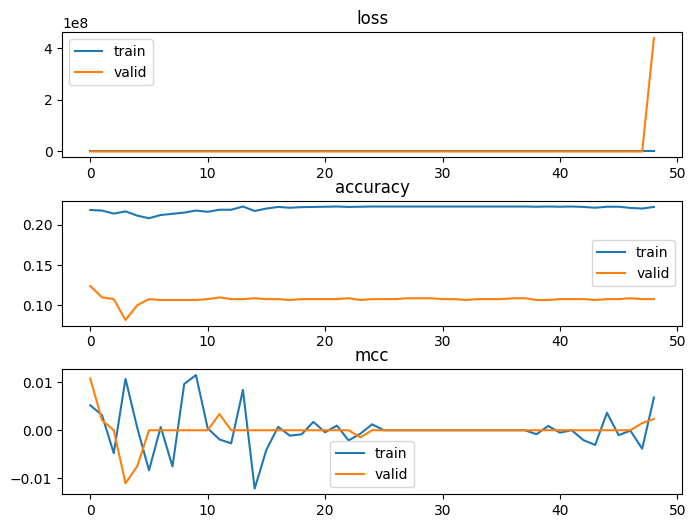

In [ ]:
metric_names = ['loss', 'accuracy', 'mcc']
_, ax = plt.subplots(len(metric_names), 1, figsize=(8, 6))

for i, m in enumerate(metric_names):
    ax[i].set_title(m)
    ax[i].plot([tm[i] for tm in train_metrics], label='train')
    ax[i].plot([vm[i] for vm in valid_metrics], label='valid')
    ax[i].legend()

plt.subplots_adjust(wspace=0., hspace=0.35)
plt.show()